<a href="https://colab.research.google.com/github/lukakelly9/capstone/blob/main/1_data_cleaning_EDA_preprocessing_and_first_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Data Cleaning, EDA, and Preprocessing
____________________________

### Imports

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Mounting Google Drive, Accessing the Image Dataset in Google Drive, and Loading the Image Dataset

In [4]:
# Mounting my drive

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# assigning proper file path to training data

training_data_dir = "/content/drive/MyDrive/GA Data Science Bootcamp/Projects/Capstone Project/Facial Recognition Data/Training/Training/"

In [6]:
# creating an instance of ImageDataGenerator for preprocessing of image data, and rescaling the pixel values to be in the range of 0.0-1.0.

training_datagen = ImageDataGenerator(rescale=1./255)

training_data_generator = training_datagen.flow_from_directory( # configuring the data generator to read, preprocess, and prepare the images for training
        training_data_dir,
        target_size=(224, 224), # resizing the input images to a target size of 224 x 224
        batch_size=32, # specifying data loading in batches of 32 samples at a time, helping memory efficiency during training
        class_mode='categorical') # specifying that the dataset contains multiple categorical classes, rather than just two (binary)

Found 28303 images belonging to 6 classes.


In [7]:
# assigning proper file path to testing data

testing_data_dir = '/content/drive/MyDrive/GA Data Science Bootcamp/Projects/Capstone Project/Facial Recognition Data/Testing/Testing/'

In [8]:
# See comments in cell two above for explanation of this cell

testing_datagen = ImageDataGenerator(rescale=1./255)

testing_data_generator = testing_datagen.flow_from_directory(
        testing_data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 7067 images belonging to 6 classes.


______________________
## **EDA**

### Sample Images from Each Emotion Category

In [ ]:
# Creating a list of all of the emotion classes in the data

emotion_classes = ['Surprise', 'Angry', 'Happy', 'Sad', 'Neutral', 'Fear']

In [ ]:
# Creating a function that takes in one of the two data directories, the emotion classes, a string specifying the dataset for title labeling,
# and number of sample images to plot in order to visualize sample images from each emotion category

def display_sample_images(data_dir, emotion_classes, dataset_type="Training", num_samples=3):
    plt.figure(figsize=(15, 10))

    for i, emotion_class in enumerate(emotion_classes):
        class_directory = os.path.join(data_dir, emotion_class)
        class_files = os.listdir(class_directory)

        # Randomly selecting num_samples images from the class
        sample_files = random.sample(class_files, num_samples)

        for j, file_name in enumerate(sample_files):
            image_path = os.path.join(class_directory, file_name)
            img = Image.open(image_path)
            plt.subplot(len(emotion_classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(emotion_class)
            plt.axis('off')

    # Setting the overall title based on the dataset_type
    if dataset_type == "Training":
        overall_title = "Training Data Sample Images"
    elif dataset_type == "Testing":
        overall_title = "Testing Data Sample Images"
    else:
        overall_title = "Sample Images"

    plt.suptitle(overall_title, fontsize=16)  # Adding overall title

    plt.show()

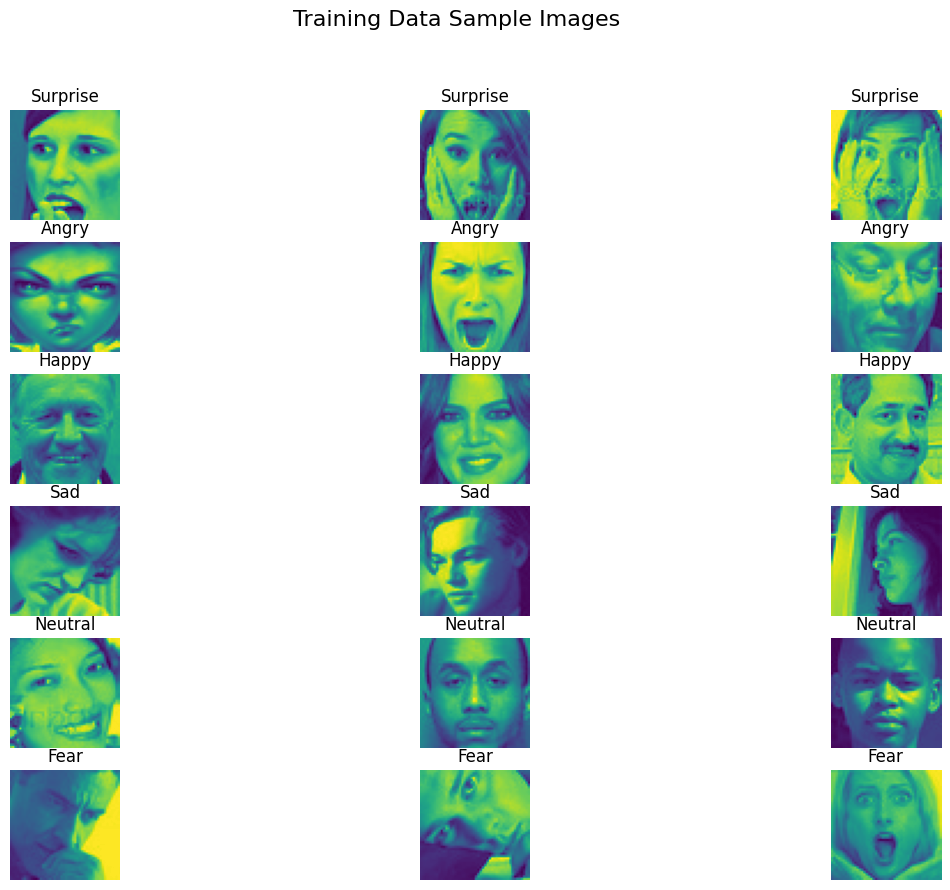

In [ ]:
# Calling the function for the training data

display_sample_images(training_data_dir, emotion_classes, num_samples=3, dataset_type= "Training")

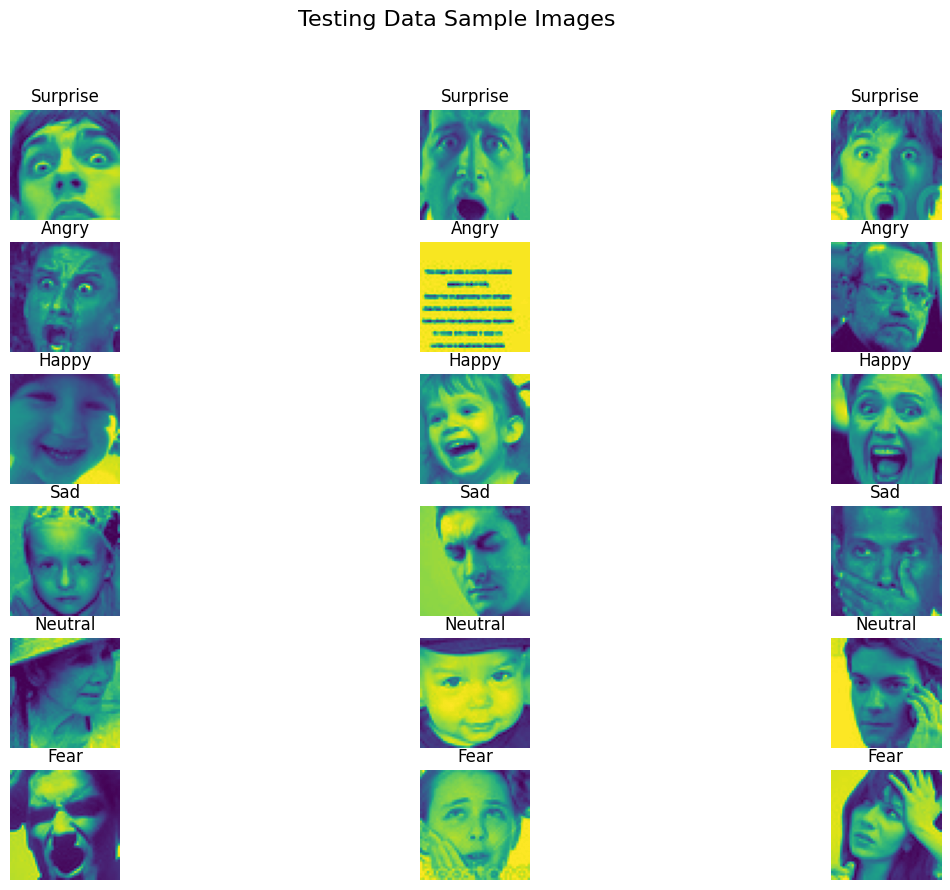

In [ ]:
# Calling the function for the testing data

display_sample_images(testing_data_dir, emotion_classes, num_samples=3, dataset_type= "Testing")

It appears that, after viewing the sample images in both the training and testing image datasets, both datasets appear to be *relatively* well labeled in terms of their classification. There are a few exceptions that we can see within the sample image plots, such as the second "Angry" image in the testing sample images. These slight mislabeling should not have a large impact on our model's ability to classify emotions/expressions when considering the size of our datasets, though.
__________________

### Emotion Class Distribution

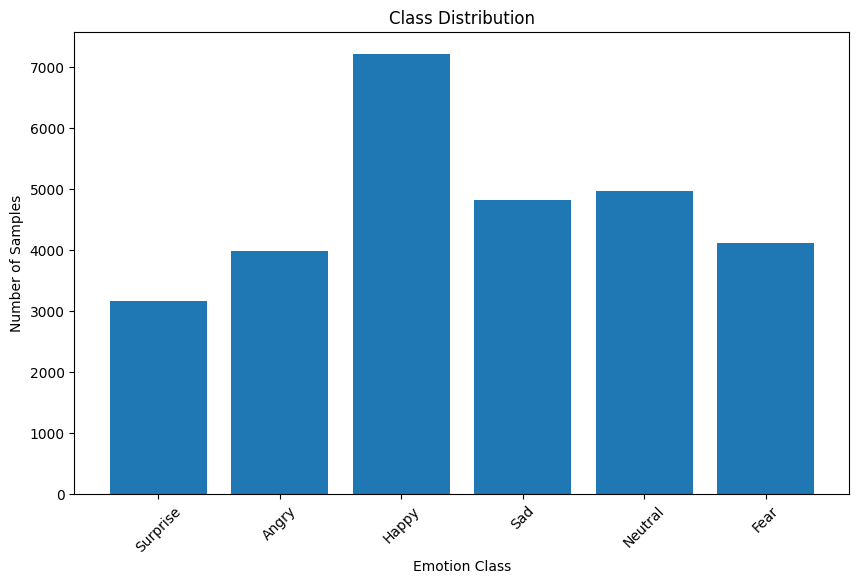

In [ ]:
# Creating a function that takes in one of the data directories and the emotion classes as arguements, and displays the distribution of the classes

def plot_class_distribution(data_dir, emotion_classes):
    class_counts = [len(os.listdir(os.path.join(data_dir, emotion_class))) for emotion_class in emotion_classes]

    plt.figure(figsize=(10, 6))
    plt.bar(emotion_classes, class_counts)
    plt.title('Class Distribution')
    plt.xlabel('Emotion Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

# Calling the function to plot the training classes distribution

plot_class_distribution(training_data_dir, emotion_classes)

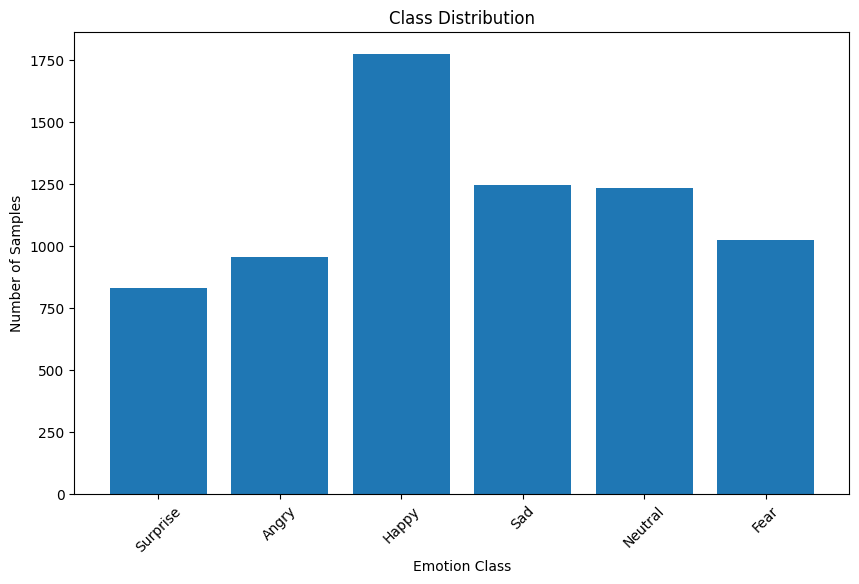

In [ ]:
# Calling the function to plot the testing classes distribution

plot_class_distribution(testing_data_dir, emotion_classes)

As one can see from the above bar plots, the emotion classes are somewhat imbalanced in both the training and testing sets, as they do not all have the same number of samples for each class. Although, as above, I do not think this should have a large impact on our models ability to discern emotion class (the only potential caveat to that might be an increased ability to classify "Happy" images, due to that class having the largest number of samples).

_______________________________________
### Displaying Image Statistics

In [ ]:
# Creating a function to compute and visualize image statistics, takes in one of the data directories and the emotion classes as arguements

def compute_image_statistics(data_dir, emotion_classes):
    for emotion_class in emotion_classes:
        class_directory = os.path.join(data_dir, emotion_class)
        class_files = os.listdir(class_directory)

        pixel_values = []
        image_dimensions = []

        for file_name in class_files:
            image_path = os.path.join(class_directory, file_name)
            img = Image.open(image_path)
            img_array = np.array(img)

            # Collecting pixel values and image dimensions
            pixel_values.extend(img_array.flatten())
            image_dimensions.append(img_array.shape)

        pixel_values = np.array(pixel_values)
        mean_pixel_value = np.mean(pixel_values)
        std_pixel_value = np.std(pixel_values)
        mean_dimensions = np.mean(image_dimensions, axis=0)

        print(f"Emotion Class: {emotion_class}")
        print(f"Mean Pixel Value: {mean_pixel_value:.2f}")
        print(f"Standard Deviation of Pixel Values: {std_pixel_value:.2f}")
        print(f"Mean Image Dimensions (Height, Width, Channels): {mean_dimensions}\n")

In [ ]:
# Calling the function to display the training image statistics

compute_image_statistics(training_data_dir, emotion_classes)

Emotion Class: Surprise
Mean Pixel Value: 146.26
Standard Deviation of Pixel Values: 64.93
Mean Image Dimensions (Height, Width, Channels): [48. 48.]

Emotion Class: Angry
Mean Pixel Value: 126.23
Standard Deviation of Pixel Values: 65.19
Mean Image Dimensions (Height, Width, Channels): [48. 48.]

Emotion Class: Happy
Mean Pixel Value: 129.43
Standard Deviation of Pixel Values: 63.38
Mean Image Dimensions (Height, Width, Channels): [48. 48.]

Emotion Class: Sad
Mean Pixel Value: 121.28
Standard Deviation of Pixel Values: 64.87
Mean Image Dimensions (Height, Width, Channels): [48. 48.]

Emotion Class: Neutral
Mean Pixel Value: 123.91
Standard Deviation of Pixel Values: 65.30
Mean Image Dimensions (Height, Width, Channels): [48. 48.]

Emotion Class: Fear
Mean Pixel Value: 135.56
Standard Deviation of Pixel Values: 64.96
Mean Image Dimensions (Height, Width, Channels): [48. 48.]



In [ ]:
# Calling the function to display the testing image statistics

compute_image_statistics(testing_data_dir, emotion_classes)

Emotion Class: Surprise
Mean Pixel Value: 146.34
Standard Deviation of Pixel Values: 65.34
Mean Image Dimensions (Height, Width, Channels): [48. 48.]

Emotion Class: Angry
Mean Pixel Value: 127.80
Standard Deviation of Pixel Values: 66.07
Mean Image Dimensions (Height, Width, Channels): [48. 48.]

Emotion Class: Happy
Mean Pixel Value: 127.64
Standard Deviation of Pixel Values: 63.22
Mean Image Dimensions (Height, Width, Channels): [48. 48.]

Emotion Class: Sad
Mean Pixel Value: 120.10
Standard Deviation of Pixel Values: 64.31
Mean Image Dimensions (Height, Width, Channels): [48. 48.]

Emotion Class: Neutral
Mean Pixel Value: 123.84
Standard Deviation of Pixel Values: 65.59
Mean Image Dimensions (Height, Width, Channels): [48. 48.]

Emotion Class: Fear
Mean Pixel Value: 135.06
Standard Deviation of Pixel Values: 65.63
Mean Image Dimensions (Height, Width, Channels): [48. 48.]



It appears that all of our classes are relatively balanced in both the training and testing sets when it comes to mean pixel value (range of ~120 to ~146), Standard Deviation of Pixel Values(range of ~63 to ~ 66), and mean image dimensions (uniformly 48 x 48).

___________________________
### Visualizing Image Dimensions

In [ ]:
# Function to plot histograms of image dimensions

def plot_image_dimension_distribution(data_dir, emotion_classes):
    heights = []
    widths = []

    for emotion_class in emotion_classes:
        class_directory = os.path.join(data_dir, emotion_class)
        class_files = os.listdir(class_directory)

        for file_name in class_files:
            image_path = os.path.join(class_directory, file_name)
            img = Image.open(image_path)
            img_array = np.array(img)
            heights.append(img_array.shape[0])
            widths.append(img_array.shape[1])

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=20, color='blue', alpha=0.7)
    plt.title('Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=20, color='green', alpha=0.7)
    plt.title('Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

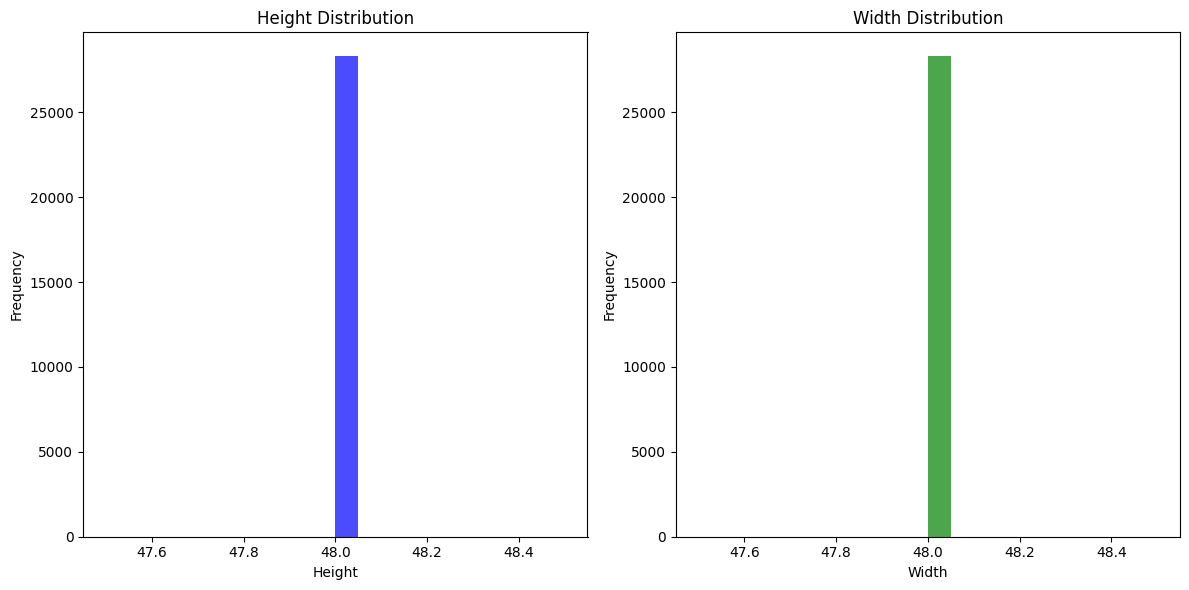

In [ ]:
# Calling the function to plot the training images dimension distribution

plot_image_dimension_distribution(training_data_dir, emotion_classes)

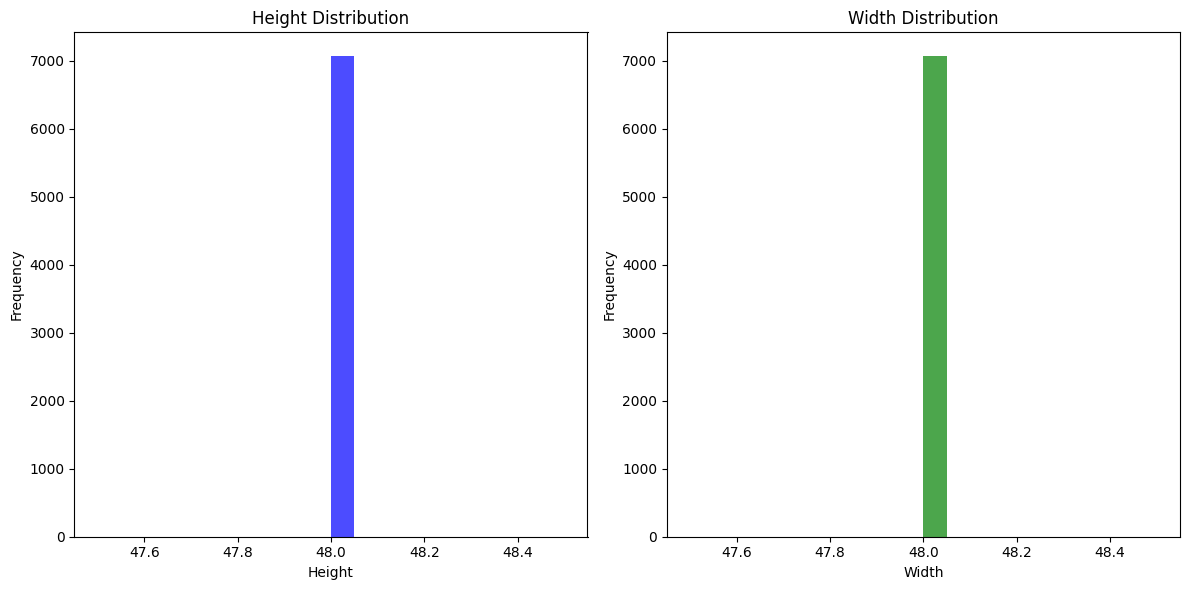

In [ ]:
 # Calling the function to plot the testing images dimension distribution

 plot_image_dimension_distribution(testing_data_dir, emotion_classes)

As we can see, both the training and testing image datasets are uniform when it comes to height and width dimensions for all images, being 48 x 48.

____________________________
## Modeling:

### Basic CNN Model - 5 Epochs, no Early Stopping or Data Augmentation

In [ ]:
# Defining the CNN model

model = Sequential() # Initializing the sequential moel

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3))) # adding in the first convolution layer with 32 filters, and input shape of 48 x 48 (dimension found above)
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu')) # second convolution layer with 64 filters
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu')) # third convolution layer with 128 filters
model.add(MaxPooling2D((2, 2)))

model.add(Flatten()) # flattening output from previous layers into a 1D vector
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # applying a dropout regularization with a rate of 0.5, to help with overfitting

model.add(Dense(6, activation='softmax'))  # 6 classes for emotions

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training the model for 5 epochs - try and except block added in due to consistent FileNotFoundErrors when trying to run model
for epoch in range(5):
    print(f"Epoch {epoch + 1}/5")
    try:
        history = model.fit(
            training_data_generator,
            steps_per_epoch=len(training_data_generator),
            epochs=1,  # Train for 1 epoch at a time
            validation_data=testing_data_generator,
            validation_steps=len(testing_data_generator)
        )
    except FileNotFoundError as e:
        print(f"FileNotFoundError: {e}")
        print("Skipping this step due to missing files in the dataset.")
        continue

Epoch 1/5
885/885 [==============================] - 3424s 4s/step - loss: 1.6362 - accuracy: 0.3284 - val_loss: 1.4702 - val_accuracy: 0.4180
Epoch 2/5
885/885 [==============================] - 3388s 4s/step - loss: 1.4168 - accuracy: 0.4368 - val_loss: 1.3470 - val_accuracy: 0.4664
Epoch 3/5
885/885 [==============================] - 3364s 4s/step - loss: 1.2737 - accuracy: 0.5030 - val_loss: 1.2991 - val_accuracy: 0.4921
Epoch 4/5
885/885 [==============================] - 3362s 4s/step - loss: 1.1362 - accuracy: 0.5594 - val_loss: 1.2954 - val_accuracy: 0.4978
Epoch 5/5
885/885 [==============================] - 3388s 4s/step - loss: 1.0065 - accuracy: 0.6117 - val_loss: 1.3247 - val_accuracy: 0.5111


It appears that our first model here is clearly improving it's accuracy score for both the training and testing sets, although with each epoch, it is becoming more overfit. Additionally, although both accuracy scores are improving, training accuracy of 0.61 and testing accuracy of 0.51 does not meet our measure of success of 70% accuracy. Next I will try a model with 10 epochs to see if our accuracy improves, and our variance decreases.